# Diabetes Risk Analysis - Classification Model Pipeline

***

## Scope of Notebook

This analysis implements a comprehensive supervised learning pipeline for diabetes risk prediction. The primary objective involves developing and optimizing classification models to identify individuals at risk of diabetes, enabling targeted public health interventions.

Table of contents:

*   [1. Setup for Modeling and Baseline Pipeline Implementation](#1-setup-for-modeling)
*   [2. Hyperparameter Optimization with Optuna](#2-hyperparameter-optimization-with-optuna)
*   [3. Threshold Optimization](#3-threshold-optimization)
*   [4. Model Performance Comparison](#4-model-performance-comparison)
*   [5. Feature Importance Validation](#5-feature-importance-validation)
*   [6. Confusion Matrix Analysis](#6-confusion-matrix-analysis)
*   [7. Comparative Threshold Analysis](#7-comparative-threshold-analysis)
*   [8. Ensemble Approach (Hard Voting)](#8-ensemble-approach-hard-voting)
*   [9. Final Model Comparison Leaderboard](#9-final-model-comparison-leaderboard)
*   [10. Automated Model Selection](#10-automated-model-selection)

In [1]:
# Import all required libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, f1_score

# Imbalanced-learn
from imblearn.over_sampling import SMOTE

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# Optuna
import optuna
from optuna.samplers import TPESampler
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

print("All libraries imported successfully!")

All libraries imported successfully!


## 1. Setup for Modeling

The modeling environment is established by loading the preprocessed dataset and configuring the feature space:
*   **Feature Selection:** Removal of unsupervised learning outputs (cluster labels, persona indicators) and the original target variable to prevent data leakage.
*   **Target Definition:** Creation of binary classification target (`Diabetes_Binary`: 0=Healthy, 1=Pre-diabetes/Diabetes).
*   **Data Splitting:** Implementation of stratified train-test split (80/20 ratio) to maintain class distribution balance.

**Baseline Pipeline Implementation**

Three classification algorithms are implemented with baseline configurations to establish performance benchmarks:
*   **Logistic Regression:** Linear model requiring feature scaling via StandardScaler.
*   **Random Forest:** Ensemble tree-based model utilizing raw features without scaling.
*   **XGBoost:** Gradient boosting framework with class weight adjustment (`scale_pos_weight=3`).

Each pipeline incorporates SMOTE (Synthetic Minority Over-sampling Technique) to address class imbalance in the training data. Additionally, Recursive Feature Elimination with Cross-Validation (RFECV) is applied to identify the optimal feature subset for maximizing recall.

Loaded Data Shape: (229781, 8)
Dropped Columns: 1
Remaining Features (6): ['Physical_Distress_Ratio', 'Healthy_Habit_Score', 'Sedentary_Risk', 'Age', 'BMI', 'GenHlth']
--------------------------------------------------
Train Shape: (183824, 6), Test Shape: (45957, 6)

Training Pipeline A (Logistic Regression)...
Training Pipeline B (Random Forest & XGBoost)...
Training Pipeline B (Random Forest & XGBoost)...

==================== Logistic Regression ====================
              precision    recall  f1-score   support

           0       0.92      0.70      0.80     38012
           1       0.33      0.72      0.45      7945

    accuracy                           0.70     45957
   macro avg       0.63      0.71      0.62     45957
weighted avg       0.82      0.70      0.74     45957


==================== Logistic Regression ====================
              precision    recall  f1-score   support

           0       0.92      0.70      0.80     38012
           1       0.33   

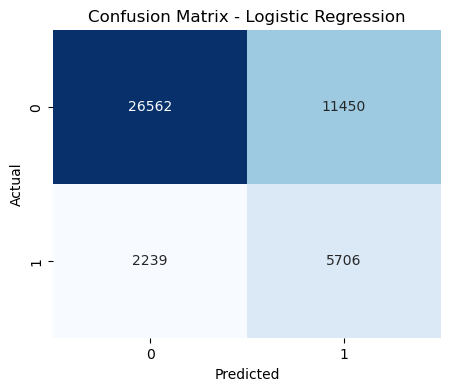


==================== Random Forest ====================
              precision    recall  f1-score   support

           0       0.87      0.81      0.84     38012
           1       0.32      0.43      0.37      7945

    accuracy                           0.75     45957
   macro avg       0.60      0.62      0.61     45957
weighted avg       0.78      0.75      0.76     45957

              precision    recall  f1-score   support

           0       0.87      0.81      0.84     38012
           1       0.32      0.43      0.37      7945

    accuracy                           0.75     45957
   macro avg       0.60      0.62      0.61     45957
weighted avg       0.78      0.75      0.76     45957



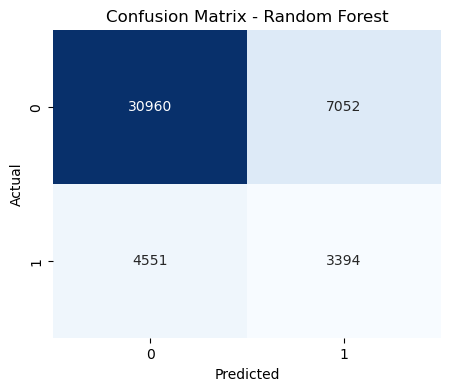


==================== XGBoost ====================
              precision    recall  f1-score   support

           0       0.94      0.53      0.68     38012
           1       0.27      0.85      0.41      7945

    accuracy                           0.58     45957
   macro avg       0.61      0.69      0.55     45957
weighted avg       0.83      0.58      0.63     45957



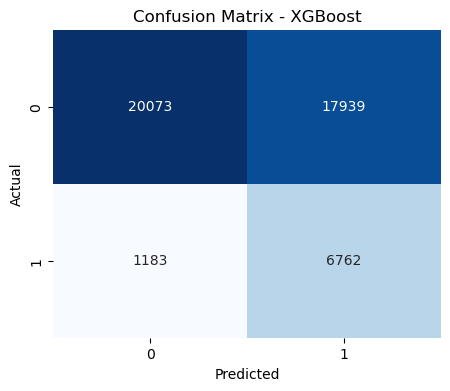


Checking Feature Importance (Baseline)...


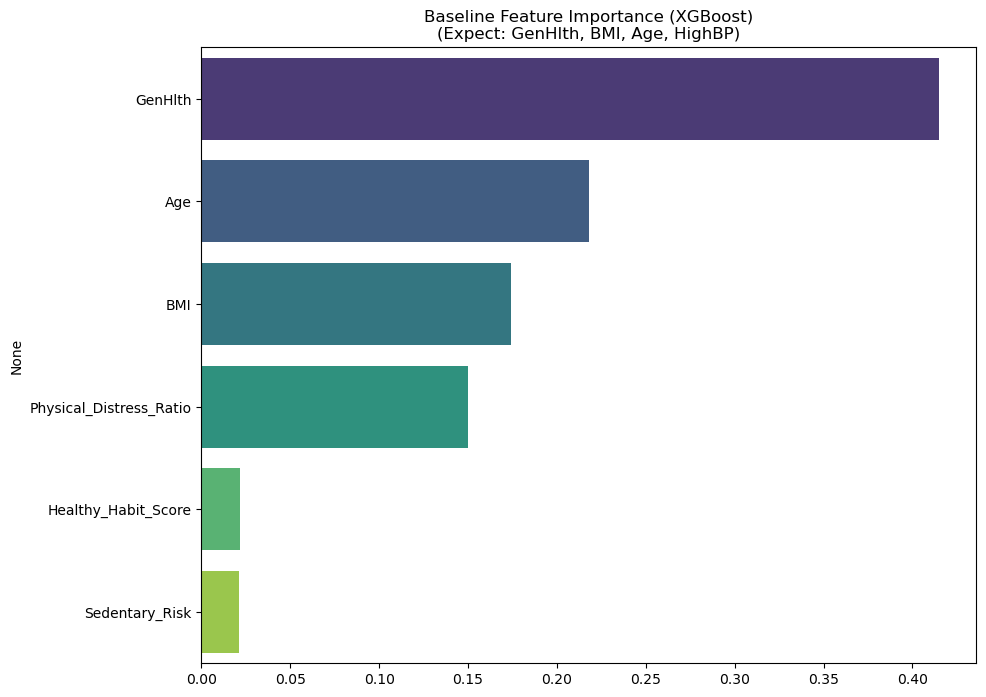


Running RFECV (Recursive Feature Elimination)...
Optimal number of features: 6
Selected Features: ['Physical_Distress_Ratio', 'Healthy_Habit_Score', 'Sedentary_Risk', 'Age', 'BMI', 'GenHlth']
Optimal number of features: 6
Selected Features: ['Physical_Distress_Ratio', 'Healthy_Habit_Score', 'Sedentary_Risk', 'Age', 'BMI', 'GenHlth']


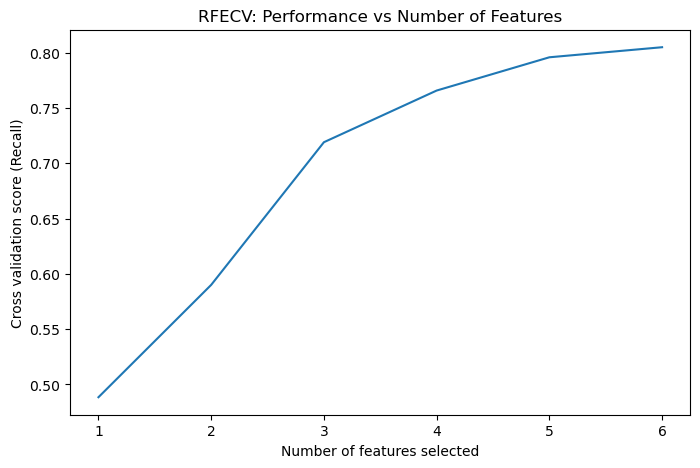

In [2]:
# --- 1. Load & Strip Data (Baseline Workflow) ---
# Load original processed data (Pre-Clustering)
try:
    df = pd.read_pickle('../data/processed/diabetes_final_processed.pkl')
    print(f"Loaded Data Shape: {df.shape}")
except FileNotFoundError:
    print("Error: Pickle file not found. Check path.")

# Feature Pruning: Remove ALL Unsupervised Outputs & Masking Variables
# Specific drops
cols_to_drop = [
    'Diabetes_012', 
    'Metabolic_Syndrome_Index', 
    'Patient_Persona', 
    'Cluster_KMeans', 
    'Cluster_Proto'
]

# Pattern-based drops (Catching OHE cluster cols and any lingering labels)
pattern_drops = [c for c in df.columns if 'Cluster' in c or 'Persona' in c or 'Proto' in c]
final_drops = list(set(cols_to_drop + pattern_drops))

# Drop and Verify
existing_drops = [c for c in final_drops if c in df.columns]
df_baseline = df.drop(columns=existing_drops)

# Target Management
if 'Diabetes_Binary' not in df_baseline.columns:
    # Re-create binary target if missing (0=Healthy, 1=Pre/Diabetes)
    if 'Diabetes_012' in df.columns:
        df_baseline['Diabetes_Binary'] = df['Diabetes_012'].apply(lambda x: 0.0 if x == 0.0 else 1.0)
    else:
        raise KeyError("Original target 'Diabetes_012' missing to create Binary target.")

X = df_baseline.drop(columns=['Diabetes_Binary'])
y = df_baseline['Diabetes_Binary']

print(f"Dropped Columns: {len(existing_drops)}")
print(f"Remaining Features ({len(X.columns)}): {list(X.columns)}")
print("-" * 50)


# --- 2. The Standard Split ---
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")


# --- 3. Pipeline A: Linear (Scaled) ---
print("\nTraining Pipeline A (Logistic Regression)...")
X_train_lin = X_train.copy()
X_test_lin = X_test.copy()

# Scale
scaler = StandardScaler()
X_train_lin_scaled = scaler.fit_transform(X_train_lin)
X_test_lin_scaled = scaler.transform(X_test_lin)

# SMOTE
smote = SMOTE(random_state=42)
X_train_lin_res, y_train_lin_res = smote.fit_resample(X_train_lin_scaled, y_train)

# Train
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_lin_res, y_train_lin_res)


# --- 4. Pipeline B: Trees (Raw) ---
print("Training Pipeline B (Random Forest & XGBoost)...")
# SMOTE on Raw
smote_raw = SMOTE(random_state=42)
X_train_res, y_train_res = smote_raw.fit_resample(X_train, y_train)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_res, y_train_res)

# Train XGBoost (Preserve hyperparameters)
xgb_model = XGBClassifier(
    scale_pos_weight=3, 
    use_label_encoder=False, 
    eval_metric='logloss', 
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train_res, y_train_res)


# --- 5. Output & Validation ---

def evaluate_model(model, X_val, y_val, name):
    print(f"\n{'='*20} {name} {'='*20}")
    y_pred = model.predict(X_val)
    print(classification_report(y_val, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Evaluate All
evaluate_model(lr_model, X_test_lin_scaled, y_test, "Logistic Regression")
evaluate_model(rf_model, X_test, y_test, "Random Forest")
evaluate_model(xgb_model, X_test, y_test, "XGBoost")


# --- Feature Importance (XGBoost) ---
print("\nChecking Feature Importance (Baseline)...")
plt.figure(figsize=(10, 8))
importances = xgb_model.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False).head(20)
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')
plt.title('Baseline Feature Importance (XGBoost)\n(Expect: GenHlth, BMI, Age, HighBP)')
plt.show()


# --- RFECV (Feature Elimination) ---
print("\nRunning RFECV (Recursive Feature Elimination)...")
# Using Random Forest as estimator for RFECV
rfecv = RFECV(
    estimator=RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1),
    step=1,
    cv=StratifiedKFold(3),
    scoring='recall'
)
rfecv.fit(X_train_res, y_train_res)

print(f"Optimal number of features: {rfecv.n_features_}")
print(f"Selected Features: {list(X.columns[rfecv.support_])}")

plt.figure(figsize=(8, 5))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (Recall)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.title("RFECV: Performance vs Number of Features")
plt.show()

## 2. Hyperparameter Optimization with Optuna

Hyperparameter tuning is performed using Optuna's Tree-structured Parzen Estimator (TPE) sampler with **Recall** as the optimization metric. This metric prioritization minimizes false negatives, ensuring high-risk individuals are correctly identified.

**Models Optimized:**
*   **Logistic Regression:** Regularization strength (C) and solver algorithm.
*   **Random Forest:** Number of estimators, maximum depth, minimum samples per split/leaf.
*   **XGBoost:** Learning rate, tree depth, subsample ratio, feature sampling ratio.

Each model undergoes 30 optimization trials with 3-fold stratified cross-validation to ensure robust parameter selection.

In [3]:
# Define Optuna objective for Logistic Regression
def objective_lr(trial):
    # Hyperparameters to tune
    C = trial.suggest_float('C', 0.001, 10.0, log=True)
    
    # Check number of classes to decide valid solvers
    n_classes = len(np.unique(y_train_lin_res))
    
    if n_classes > 2:
        # For multiclass, avoid liblinear unless OneVsRest is used (simplest to just use lbfgs/saga)
        solver = trial.suggest_categorical('solver', ['lbfgs', 'saga'])
    else:
        # For binary, all are fine
        solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga'])
    
    # Create model
    model = LogisticRegression(C=C, solver=solver, max_iter=1000, random_state=42)
    
    # Stratified K-Fold cross-validation
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    # Calculate recall scores using LINEAR RESAMPLED data
    # Note: 'recall' defaults to binary. For multiclass, use 'recall_macro' or 'recall_weighted'
    scoring_metric = 'recall' if n_classes == 2 else 'recall_weighted'
    
    try:
        recall_scores = cross_val_score(model, X_train_lin_res, y_train_lin_res, 
                                         cv=skf, scoring=scoring_metric)
        return recall_scores.mean()
    except ValueError:
        # Fallback if solver fails (though lbfgs/saga should work)
        return 0.0

# Print info about the target before optimization
print(f"Target classes in training data: {np.unique(y_train_lin_res)}")

# Run Optuna study for Logistic Regression
print("Optimizing Logistic Regression (Path A)...")
sampler = TPESampler(seed=42)
study_lr = optuna.create_study(direction='maximize', sampler=sampler)
study_lr.optimize(objective_lr, n_trials=30, show_progress_bar=True)

print(f"\nBest Logistic Regression parameters:")
print(f"  C: {study_lr.best_params['C']:.4f}")
print(f"  solver: {study_lr.best_params['solver']}")
print(f"  Best Recall: {study_lr.best_value:.4f}")

Target classes in training data: [0 1]
Optimizing Logistic Regression (Path A)...


Best trial: 23. Best value: 0.729813: 100%|██████████| 30/30 [00:23<00:00,  1.28it/s]


Best Logistic Regression parameters:
  C: 0.0010
  solver: liblinear
  Best Recall: 0.7298


In [4]:
# Define Optuna objective for Random Forest
def objective_rf(trial):
    # Hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    # Create model
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )
    
    # Stratified K-Fold cross-validation
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    # Calculate recall scores using RAW RESAMPLED data
    recall_scores = cross_val_score(model, X_train_res, y_train_res, 
                                     cv=skf, scoring='recall')
    
    return recall_scores.mean()

# Run Optuna study for Random Forest
print("Optimizing Random Forest (Path B)...")
sampler = TPESampler(seed=42)
study_rf = optuna.create_study(direction='maximize', sampler=sampler)
study_rf.optimize(objective_rf, n_trials=30, show_progress_bar=True)

print(f"\nBest Random Forest parameters:")
print(f"  Best Recall: {study_rf.best_value:.4f}")

Optimizing Random Forest (Path B)...


Best trial: 19. Best value: 0.837987: 100%|██████████| 30/30 [11:06<00:00, 22.21s/it]


Best Random Forest parameters:
  Best Recall: 0.8380


In [5]:
# Define Optuna objective for XGBoost
def objective_xgb(trial):
    # Hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
    
    # Create model (Fixed scale_pos_weight=3 as per new pipeline)
    model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        scale_pos_weight=3, 
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42,
        n_jobs=-1
    )
    
    # Stratified K-Fold cross-validation
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    # Calculate recall scores using RAW RESAMPLED data
    recall_scores = cross_val_score(model, X_train_res, y_train_res, 
                                     cv=skf, scoring='recall')
    
    return recall_scores.mean()

# Run Optuna study for XGBoost
print("Optimizing XGBoost (Path B)...")
sampler = TPESampler(seed=42)
study_xgb = optuna.create_study(direction='maximize', sampler=sampler)
study_xgb.optimize(objective_xgb, n_trials=30, show_progress_bar=True)

print(f"\nBest XGBoost parameters:")
print(f"  Best Recall: {study_xgb.best_value:.4f}")

Optimizing XGBoost (Path B)...


Best trial: 23. Best value: 0.995883: 100%|██████████| 30/30 [01:02<00:00,  2.08s/it]


Best XGBoost parameters:
  Best Recall: 0.9959


## 3. Threshold Optimization

The default classification threshold of 0.5 may prove suboptimal for public health applications where recall maximization is prioritized. A systematic threshold search is conducted across the range [0.1, 0.95] to identify the decision boundary that maximizes recall while maintaining acceptable precision (≥30%).


**Methodology:**Visualization of the precision-recall tradeoff curve facilitates understanding of the threshold impact on model behavior.

*   **Threshold Range:** 0.10 to 0.95 in increments of 0.05.

*   **Selection Criteria:** Maximization of recall subject to minimum precision constraint.*   **Fallback Strategy:** If precision constraint cannot be satisfied, F1-Score maximization is employed.

In [6]:
# Retrain best models on the full resampled training sets (Split-Paths)

# 1. Logistic Regression (Path A - Scaled)
best_lr = LogisticRegression(**study_lr.best_params, max_iter=1000, random_state=42)
best_lr.fit(X_train_lin_res, y_train_lin_res)

# 2. Random Forest (Path B - Raw)
best_rf = RandomForestClassifier(**study_rf.best_params, random_state=42, n_jobs=-1)
best_rf.fit(X_train_res, y_train_res)

# 3. XGBoost (Path B - Raw)
best_xgb = XGBClassifier(**study_xgb.best_params, scale_pos_weight=3, 
                         eval_metric='logloss', use_label_encoder=False, 
                         random_state=42, n_jobs=-1)
best_xgb.fit(X_train_res, y_train_res)

print("Final models trained successfully on Split-Path data!")

Final models trained successfully on Split-Path data!


In [7]:
# Function to find optimal threshold for Recall
def find_optimal_threshold(model, X_val, y_val, model_name, min_precision=0.3):
    # Get probabilities for the positive class
    y_proba = model.predict_proba(X_val)[:, 1]
    
    thresholds = np.arange(0.1, 0.95, 0.05)
    results_list = []
    
    for t in thresholds:
        y_pred_t = (y_proba >= t).astype(int)
        results_list.append({
            'threshold': t,
            'recall': recall_score(y_val, y_pred_t, zero_division=0),
            'precision': precision_score(y_val, y_pred_t, zero_division=0),
            'f1': f1_score(y_val, y_pred_t, zero_division=0)
        })
        
    results_df = pd.DataFrame(results_list)
    
    # Selection Criteria: Maximize Recall where Precision >= min_precision
    valid_results = results_df[results_df['precision'] >= min_precision]
    
    if not valid_results.empty:
        best_row = valid_results.loc[valid_results['recall'].idxmax()]
    else:
        # Fallback: Maximize F1 if precision constraint is too hard
        print(f"[{model_name}] Warning: No threshold met precision >= {min_precision}. Maximizing F1.")
        best_row = results_df.loc[results_df['f1'].idxmax()]
    
    opt_threshold = best_row['threshold']
    print(f"Optimal Threshold for {model_name}: {opt_threshold:.2f} (Recall: {best_row['recall']:.4f}, Precision: {best_row['precision']:.4f})")
    
    return opt_threshold, y_proba, results_df

optimal_thresholds = {}
models = {}
models_default = {}

# 1. Logistic Regression (Path A - Scaled Data)
# Note: Use X_test_lin_scaled
lr_threshold, y_proba_lr, lr_results = find_optimal_threshold(
    best_lr, X_test_lin_scaled, y_test, "Logistic Regression"
)
optimal_thresholds['Logistic Regression'] = lr_threshold
y_pred_lr_opt = (y_proba_lr >= lr_threshold).astype(int)
models['Logistic Regression'] = (best_lr, y_pred_lr_opt, lr_threshold)
models_default['Logistic Regression'] = best_lr.predict(X_test_lin_scaled)

# 2. Random Forest (Path B - Raw Data)
# Note: Use X_test
rf_threshold, y_proba_rf, rf_results = find_optimal_threshold(
    best_rf, X_test, y_test, "Random Forest"
)
optimal_thresholds['Random Forest'] = rf_threshold
y_pred_rf_opt = (y_proba_rf >= rf_threshold).astype(int)
models['Random Forest'] = (best_rf, y_pred_rf_opt, rf_threshold)
models_default['Random Forest'] = best_rf.predict(X_test)

# 3. XGBoost (Path B - Raw Data)
# Note: Use X_test
xgb_threshold, y_proba_xgb, xgb_results = find_optimal_threshold(
    best_xgb, X_test, y_test, "XGBoost"
)
optimal_thresholds['XGBoost'] = xgb_threshold
y_pred_xgb_opt = (y_proba_xgb >= xgb_threshold).astype(int)
models['XGBoost'] = (best_xgb, y_pred_xgb_opt, xgb_threshold)
models_default['XGBoost'] = best_xgb.predict(X_test)

Optimal Threshold for Logistic Regression: 0.45 (Recall: 0.7862, Precision: 0.3082)
Optimal Threshold for Random Forest: 0.40 (Recall: 0.7069, Precision: 0.3108)
Optimal Threshold for Random Forest: 0.40 (Recall: 0.7069, Precision: 0.3108)
Optimal Threshold for XGBoost: 0.75 (Recall: 0.6289, Precision: 0.3652)
Optimal Threshold for XGBoost: 0.75 (Recall: 0.6289, Precision: 0.3652)


## 4. Model Performance Comparison

A comprehensive evaluation compares model performance using both default (0.5) and optimized thresholds. Metrics include:
*   **Recall:** Proportion of actual positive cases correctly identified (priority metric).
*   **Precision:** Proportion of predicted positive cases that are truly positive.
*   **F1-Score:** Harmonic mean of precision and recall.
*   **Accuracy:** Overall correctness (reported but not prioritized due to class imbalance).

Comparative analysis reveals the performance gain achieved through threshold optimization and identifies the superior model for deployment.

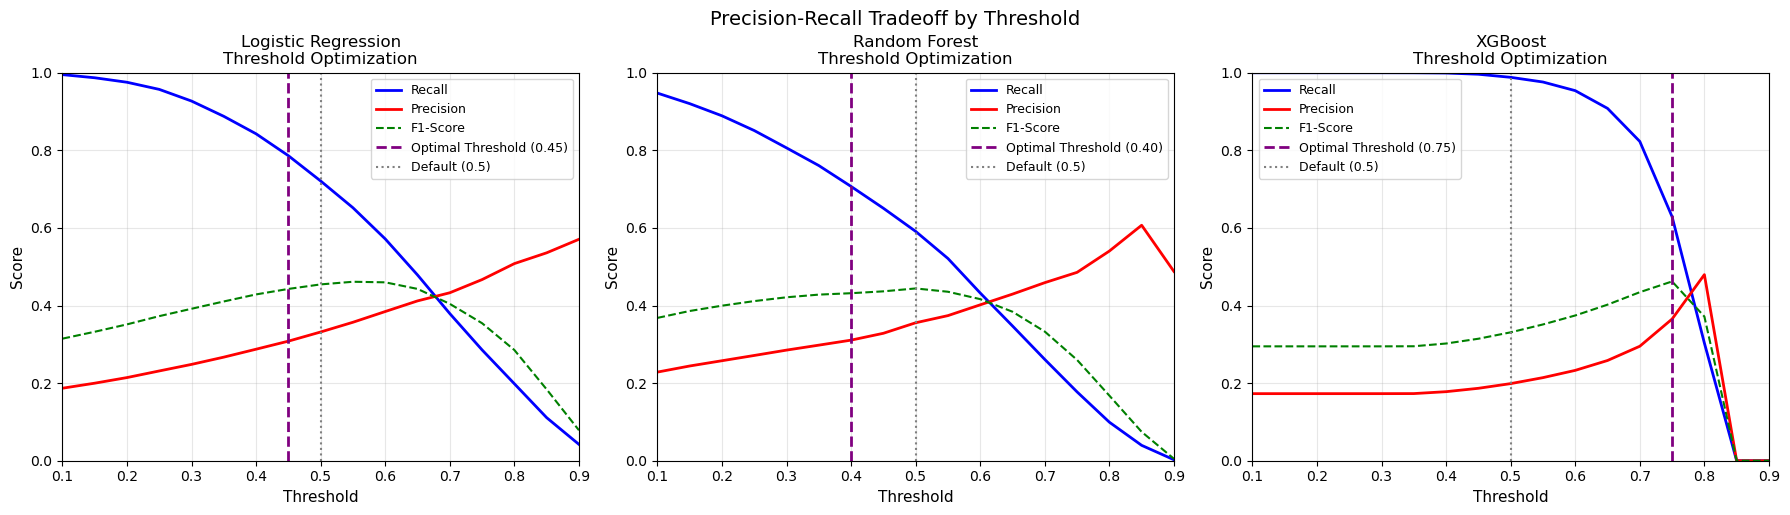

In [8]:
# Visualize Precision-Recall tradeoff for each model
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

model_results = [
    ('Logistic Regression', lr_results, lr_threshold),
    ('Random Forest', rf_results, rf_threshold),
    ('XGBoost', xgb_results, xgb_threshold)
]

for idx, (name, results, opt_threshold) in enumerate(model_results):
    ax = axes[idx]
    
    # Plot recall and precision vs threshold
    ax.plot(results['threshold'], results['recall'], 'b-', label='Recall', linewidth=2)
    ax.plot(results['threshold'], results['precision'], 'r-', label='Precision', linewidth=2)
    ax.plot(results['threshold'], results['f1'], 'g--', label='F1-Score', linewidth=1.5)
    
    # Mark optimal threshold
    ax.axvline(x=opt_threshold, color='purple', linestyle='--', linewidth=2, 
               label=f'Optimal Threshold ({opt_threshold:.2f})')
    ax.axvline(x=0.5, color='gray', linestyle=':', linewidth=1.5, 
               label='Default (0.5)')
    
    ax.set_xlabel('Threshold', fontsize=11)
    ax.set_ylabel('Score', fontsize=11)
    ax.set_title(f'{name}\nThreshold Optimization', fontsize=12)
    ax.legend(loc='best', fontsize=9)
    ax.set_xlim(0.1, 0.9)
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Precision-Recall Tradeoff by Threshold', fontsize=14, y=1.02)
plt.show()

In [9]:
# Summary comparison: Default Threshold vs Optimized Threshold
print("=" * 90)
print("MODEL PERFORMANCE COMPARISON: Default (0.5) vs Optimized Thresholds")
print("=" * 90)

comparison_data = []

for model_name, (model, y_pred_opt, opt_threshold) in models.items():
    y_pred_def = models_default[model_name]
    
    # Default threshold metrics
    # Handle zero_division=0 to prevent warnings if precision is 0
    recall_def = recall_score(y_test, y_pred_def, zero_division=0)
    precision_def = precision_score(y_test, y_pred_def, zero_division=0)
    f1_def = f1_score(y_test, y_pred_def, zero_division=0)
    
    # Optimized threshold metrics
    recall_opt = recall_score(y_test, y_pred_opt, zero_division=0)
    precision_opt = precision_score(y_test, y_pred_opt, zero_division=0)
    f1_opt = f1_score(y_test, y_pred_opt, zero_division=0)
    
    comparison_data.append({
        'Model': model_name,
        'Threshold': 0.5,
        'Recall': recall_def,
        'Precision': precision_def,
        'F1-Score': f1_def
    })
    
    comparison_data.append({
        'Model': model_name,
        'Threshold': opt_threshold,
        'Recall': recall_opt,
        'Precision': precision_opt,
        'F1-Score': f1_opt
    })

comparison_df = pd.DataFrame(comparison_data)

# Display formatted table
display(comparison_df.style.format({
    'Threshold': '{:.2f}',
    'Recall': '{:.2%}',
    'Precision': '{:.2%}',
    'F1-Score': '{:.2%}'
}).background_gradient(cmap='Greens', subset=['Recall']))

# Final summary with optimized thresholds
print("\n" + "=" * 90)
print("FINAL MODEL PERFORMANCE SUMMARY (Optimized Thresholds)")
print("=" * 90)

final_summary = []
for model_name, (model, y_pred, threshold) in models.items():
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Robustly identify the positive class key
    # Target is float (0.0/1.0), so key is likely '1.0'. Checking all variants.
    pos_keys = ['Diabetes', '1.0', '1', 1, 1.0]
    pos_key = next((k for k in pos_keys if k in report), None)
    
    if pos_key is None:
        # Fallback: Find any key that isn't 'accuracy' or averages or '0'/'0.0'
        # This assumes binary classification and looks for the "other" class
        candidates = [k for k in report.keys() if k not in ['accuracy', 'macro avg', 'weighted avg', '0', '0.0', 0, 0.0]]
        if candidates:
            pos_key = candidates[0]
            
    if pos_key:
        final_summary.append({
            'Model': model_name,
            'Threshold': threshold,
            'Accuracy': report['accuracy'],
            'Precision (Diabetes)': report[pos_key]['precision'],
            'Recall (Diabetes)': report[pos_key]['recall'],
            'F1-Score (Diabetes)': report[pos_key]['f1-score']
        })
    else:
        print(f"Warning: Could not identify positive class key for {model_name}. Report keys: {list(report.keys())}")

final_df = pd.DataFrame(final_summary).set_index('Model')

display(final_df.style.format({
    'Threshold': '{:.2f}',
    'Accuracy': '{:.2%}',
    'Precision (Diabetes)': '{:.2%}',
    'Recall (Diabetes)': '{:.2%}',
    'F1-Score (Diabetes)': '{:.2%}'
}).background_gradient(cmap='Greens', subset=['Recall (Diabetes)']))

# Identify best model by recall
if not final_df.empty:
    best_model_name = final_df['Recall (Diabetes)'].idxmax()
    best_threshold = final_df.loc[best_model_name, 'Threshold']
    best_recall = final_df.loc[best_model_name, 'Recall (Diabetes)']

    print(f"\n Best Model by Recall: {best_model_name}")
    print(f"   Optimal Threshold: {best_threshold:.2f}")
    print(f"   Recall: {best_recall:.2%}")
else:
    print("No valid models found in summary.")

MODEL PERFORMANCE COMPARISON: Default (0.5) vs Optimized Thresholds


,Model,Threshold,Recall,Precision,F1-Score
0,Logistic Regression,0.50,72.10%,33.18%,45.45%
1,Logistic Regression,0.45,78.62%,30.82%,44.28%
2,Random Forest,0.50,59.11%,35.56%,44.40%
3,Random Forest,0.40,70.69%,31.08%,43.18%
4,XGBoost,0.50,98.82%,19.87%,33.09%
5,XGBoost,0.75,62.89%,36.52%,46.21%



FINAL MODEL PERFORMANCE SUMMARY (Optimized Thresholds)


,Threshold,Accuracy,Precision (Diabetes),Recall (Diabetes),F1-Score (Diabetes)
Model,,,,,
Logistic Regression,0.45,65.79%,30.82%,78.62%,44.28%
Random Forest,0.40,67.84%,31.08%,70.69%,43.18%
XGBoost,0.75,74.69%,36.52%,62.89%,46.21%



 Best Model by Recall: Logistic Regression
   Optimal Threshold: 0.45
   Recall: 78.62%


## 5. Feature Importance Validation

Feature importance analysis is conducted using tree-based model interpretability to validate the contribution of engineered features and detect potential data leakage. Examination of importance distributions ensures that:
*   **Clinical Variables:** Key health indicators (BMI, General Health, Age, Blood Pressure) demonstrate substantial predictive power.

*   **Engineered Features:** Cluster-derived features contribute meaningful information without dominating the model (importance <50%).**Leakage Detection:** If cluster labels exhibit disproportionate importance (>50% of total), this indicates potential target leakage, requiring feature exclusion.


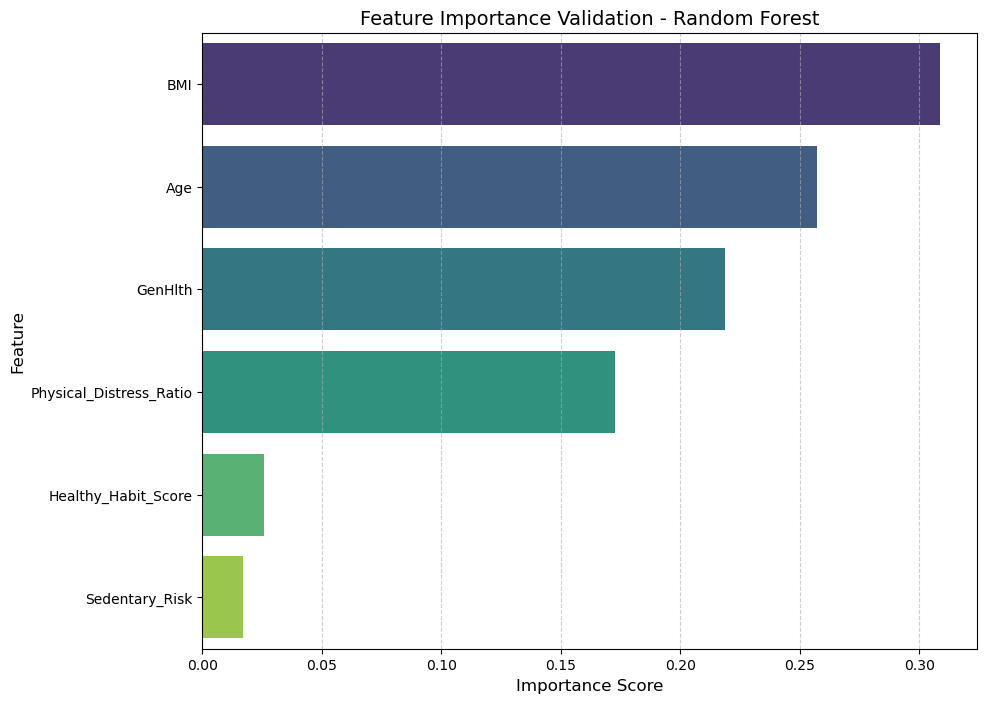


--- Random Forest Leakage Check ---
Top feature: 'BMI' (30.89% of total importance)
VALIDATION PASS: Feature importance is distributed. Cluster labels are contributing but not overpowering raw data.
--------------------------------------



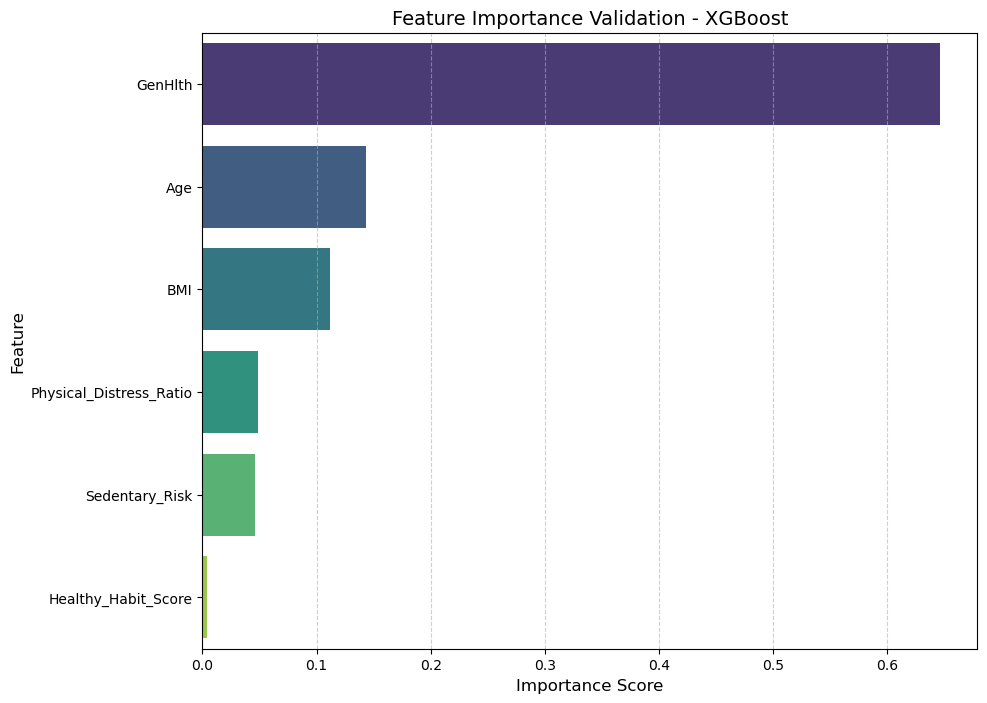


--- XGBoost Leakage Check ---
Top feature: 'GenHlth' (64.66% of total importance)
VALIDATION PASS: Feature importance is distributed. Cluster labels are contributing but not overpowering raw data.
--------------------------------



In [10]:
# Function to analyze and plot feature importance
def analyze_feature_importance(model, feature_names, model_name):
    """
    Analyzes, plots, and validates feature importances for a given model.
    """
    # Extract feature importances
    importances = model.feature_importances_
    
    # Validation check for length mismatch
    if len(importances) != len(feature_names):
        print(f"Warning: Length mismatch. Model has {len(importances)} features, provided names have {len(feature_names)}.")
        return

    # Create DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    # --- Visualization ---
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='viridis')
    plt.title(f'Feature Importance Validation - {model_name}', fontsize=14)
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()
    
    # --- Leakage Check ---
    top_feature = importance_df.iloc[0]
    top_feature_name = top_feature['Feature']
    top_feature_importance_pct = top_feature['Importance'] / importance_df['Importance'].sum() * 100
    
    print(f"\n--- {model_name} Leakage Check ---")
    print(f"Top feature: '{top_feature_name}' ({top_feature_importance_pct:.2f}% of total importance)")
    
    is_cluster_feature = 'Persona' in top_feature_name or 'Proto' in top_feature_name
    
    if is_cluster_feature and top_feature_importance_pct > 50:
        print("WARNING: Potential Leakage Detected. The cluster label is dominating the model.")
    else:
        print("VALIDATION PASS: Feature importance is distributed. Cluster labels are contributing but not overpowering raw data.")
    print("-" * (len(model_name) + 25) + "\n")

# Use ALL features (RFE was skipped in this robust pipeline)
feature_names_all = X.columns

# Analyze Random Forest
analyze_feature_importance(best_rf, feature_names_all, 'Random Forest')

# Analyze XGBoost
analyze_feature_importance(best_xgb, feature_names_all, 'XGBoost')

## 6. Confusion Matrix Analysis


Confusion matrices are constructed for each optimized model to visualize classification performance across both classes:This analysis enables assessment of the models' ability to minimize Type II errors (false negatives), which is the primary objective.

*   **True Negatives (TN):** Healthy individuals correctly identified.

*   **False Positives (FP):** Healthy individuals incorrectly flagged as at-risk.*   **True Positives (TP):** At-risk individuals correctly identified.
*   **False Negatives (FN):** At-risk individuals missed by the model (critical error in public health context).

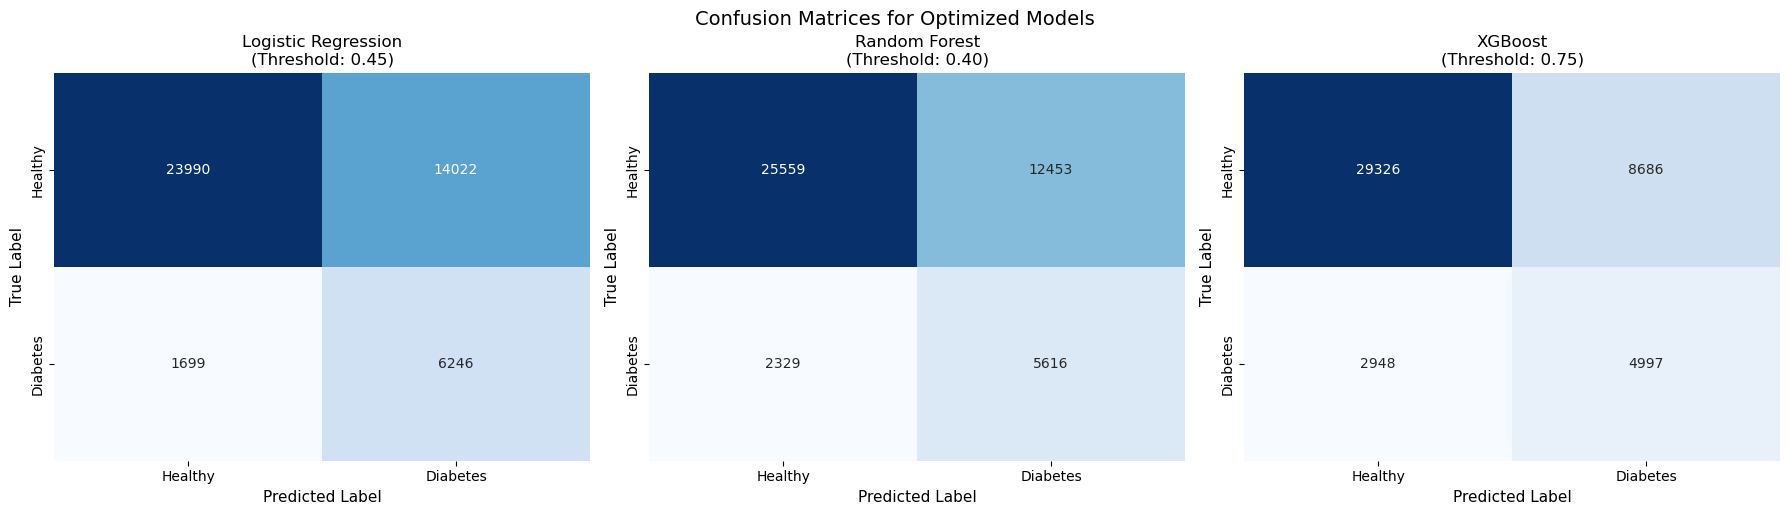

In [11]:
# Plot Confusion Matrix for each optimized model
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (model_name, (model, y_pred_opt, opt_threshold)) in enumerate(models.items()):
    ax = axes[i]
    
    # Calculate confusion matrix using the optimized predictions
    cm = confusion_matrix(y_test, y_pred_opt)
    
    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    
    ax.set_title(f'{model_name}\n(Threshold: {opt_threshold:.2f})', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=11)
    ax.set_ylabel('True Label', fontsize=11)
    ax.set_xticklabels(['Healthy', 'Diabetes'])
    ax.set_yticklabels(['Healthy', 'Diabetes'])

plt.tight_layout()
plt.suptitle('Confusion Matrices for Optimized Models', fontsize=14, y=1.02)
plt.show()

## 7. Comparative Threshold Analysis


Side-by-side comparison of confusion matrices illustrates the impact of threshold optimization on classification behavior. This visualization demonstrates:The comparative analysis validates the threshold optimization strategy and quantifies the improvement in case detection rate.

*   **Threshold Effect on Recall:** Reduction in false negatives achieved through lowered decision boundaries.

*   **Precision Tradeoff:** Corresponding increase in false positives as the model becomes more sensitive.*   **Clinical Implications:** Justification for accepting lower precision in exchange for higher recall in screening contexts.

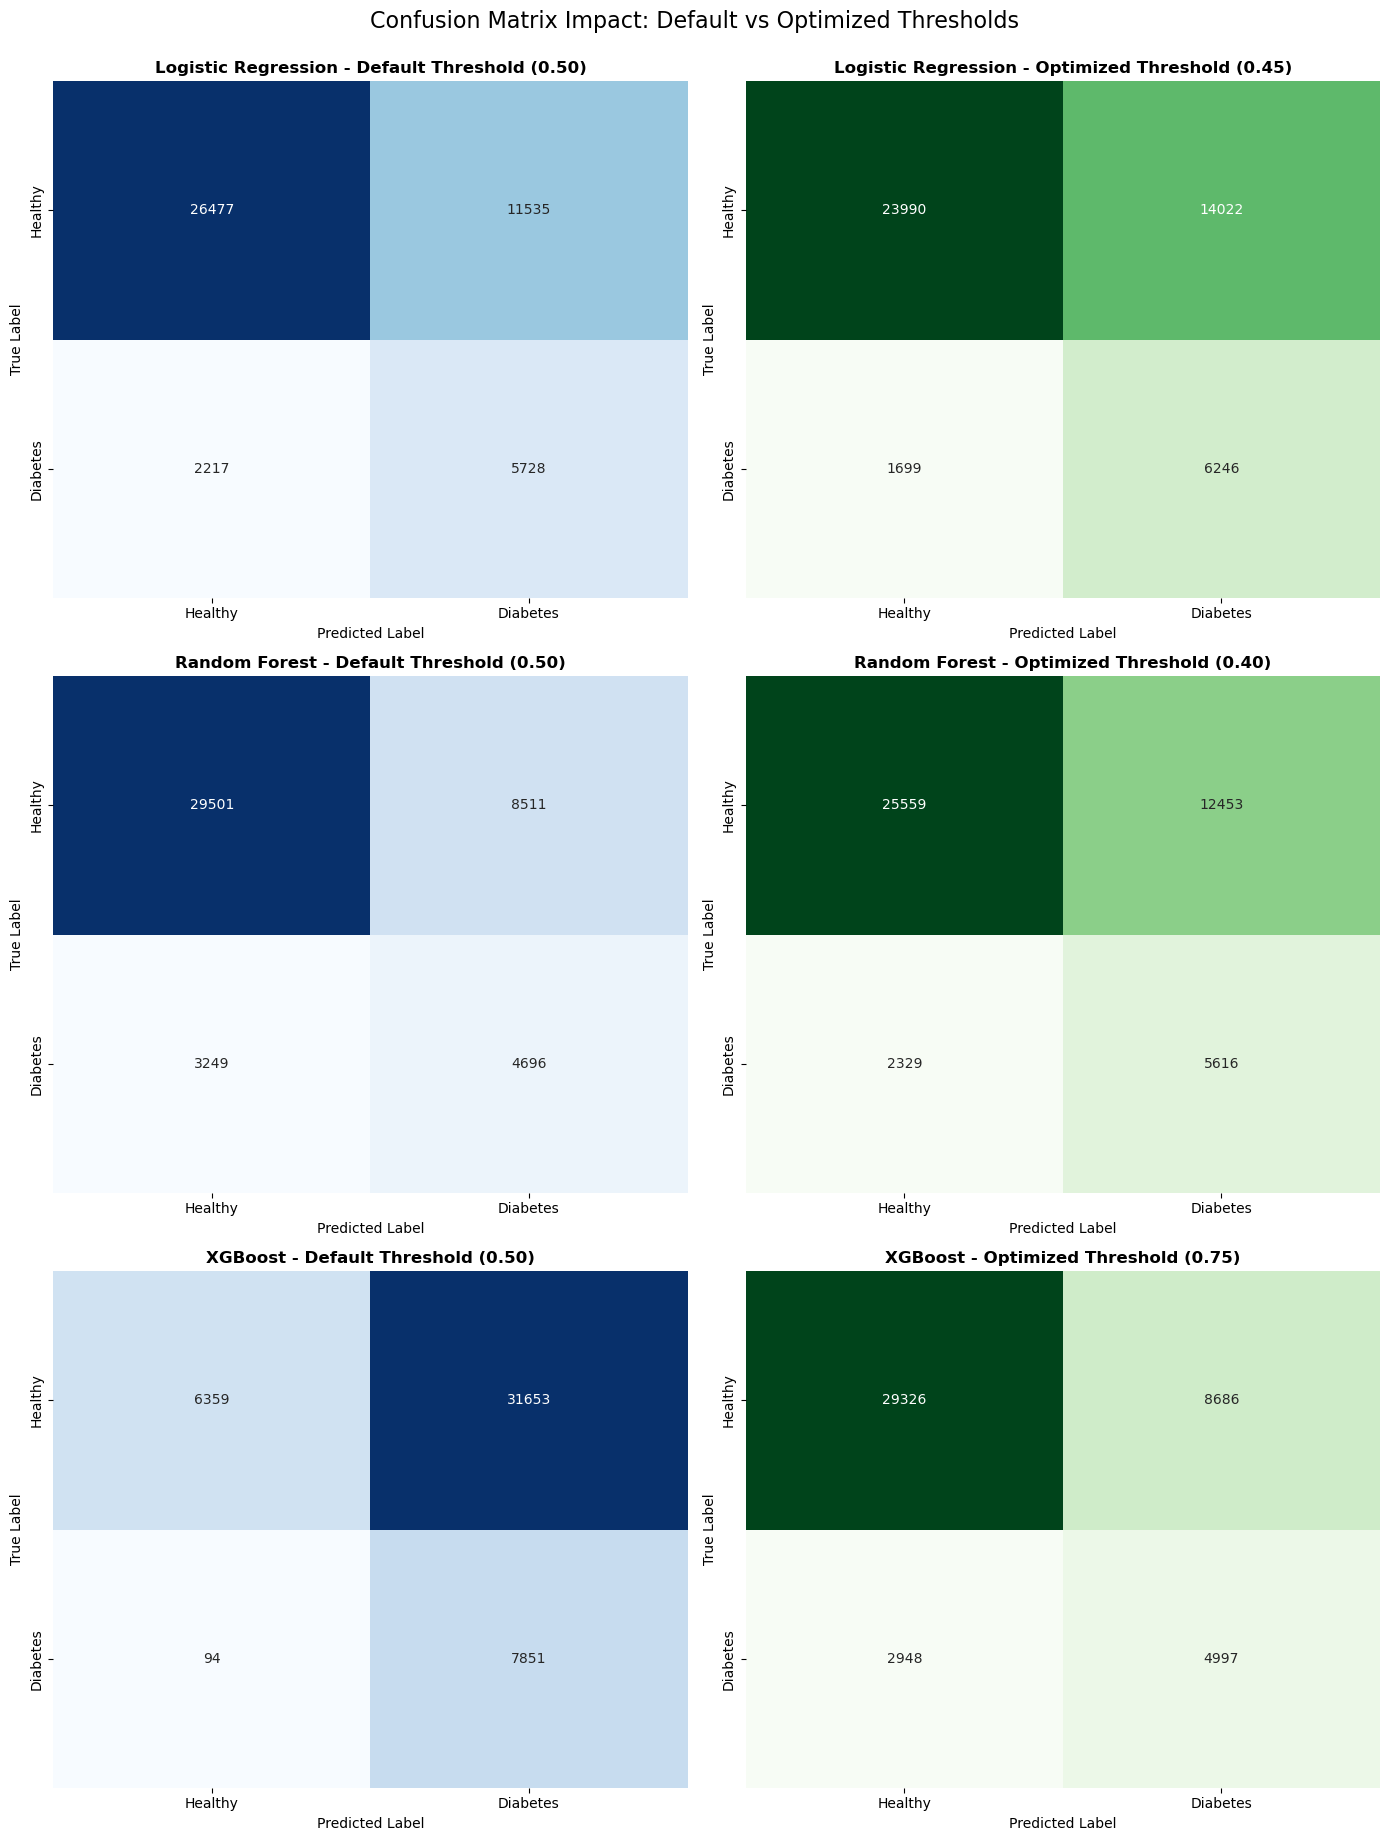

In [12]:
# Visualization: Confusion Matrix Comparison (Default vs Optimized)
fig, axes = plt.subplots(3, 2, figsize=(14, 18))

# Map model keys to nice names if needed
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost']

for i, name in enumerate(model_names):
    # Row i, Col 0: Default Threshold
    ax_def = axes[i, 0]
    y_pred_def = models_default[name] # Predictions with default 0.5 threshold
    cm_def = confusion_matrix(y_test, y_pred_def)
    
    sns.heatmap(cm_def, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax_def)
    ax_def.set_title(f'{name} - Default Threshold (0.50)', fontsize=12, fontweight='bold')
    ax_def.set_ylabel('True Label')
    ax_def.set_xlabel('Predicted Label')
    ax_def.set_xticklabels(['Healthy', 'Diabetes'])
    ax_def.set_yticklabels(['Healthy', 'Diabetes'])

    # Row i, Col 1: Optimized Threshold
    ax_opt = axes[i, 1]
    # Retrieve optimized data: model, predictions, threshold
    _, y_pred_opt, opt_thresh = models[name]
    cm_opt = confusion_matrix(y_test, y_pred_opt)
    
    sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Greens', cbar=False, ax=ax_opt)
    ax_opt.set_title(f'{name} - Optimized Threshold ({opt_thresh:.2f})', fontsize=12, fontweight='bold')
    ax_opt.set_ylabel('True Label')
    ax_opt.set_xlabel('Predicted Label')
    ax_opt.set_xticklabels(['Healthy', 'Diabetes'])
    ax_opt.set_yticklabels(['Healthy', 'Diabetes'])

plt.tight_layout()
plt.suptitle('Confusion Matrix Impact: Default vs Optimized Thresholds', fontsize=16, y=1.02)
plt.show()

## 8. Ensemble Approach (Hard Voting)

Performance enhancement is achieved through ensemble learning utilizing a **Hard Voting** strategy with weighted predictions. Unlike soft voting (probability averaging), this approach combines binary predictions from individually optimized models to produce robust classifications.

### Methodology

**Ensemble Configuration:**
*   **Component Models:** Logistic Regression, Random Forest, XGBoost (each using optimized thresholds).
*   **Weighting Scheme:** [2, 1, 1] favoring Logistic Regression due to superior recall optimization.
*   **Decision Rule:** Classification as "At Risk" (positive class) requires weighted vote sum ≥ 2.

### Decision Logic


The weighted voting mechanism enables:This ensemble architecture balances individual model strengths while maintaining the primary focus on recall optimization for public health screening applications.

*   **High-Confidence Detection:** Logistic Regression alone (weight=2) can trigger positive classification.

*   **Consensus Detection:** Agreement between Random Forest and XGBoost (1+1=2) achieves classification threshold.*   **Recall Maximization:** The asymmetric weighting prioritizes the model optimized for false negative minimization.

Evaluating Ensemble Model (Hard Voting with Optimized Thresholds except XGB)...

==================== Hard Voting Ensemble ====================
Weights: LR=2, RF=1, XGB=1
Thresholds used: LR=0.45, RF=0.40, XGB=0.50 (Default)
              precision    recall  f1-score   support

           0       0.94      0.58      0.72     38012
           1       0.29      0.83      0.43      7945

    accuracy                           0.62     45957
   macro avg       0.62      0.70      0.57     45957
weighted avg       0.83      0.62      0.67     45957


==================== Hard Voting Ensemble ====================
Weights: LR=2, RF=1, XGB=1
Thresholds used: LR=0.45, RF=0.40, XGB=0.50 (Default)
              precision    recall  f1-score   support

           0       0.94      0.58      0.72     38012
           1       0.29      0.83      0.43      7945

    accuracy                           0.62     45957
   macro avg       0.62      0.70      0.57     45957
weighted avg       0.83      0.

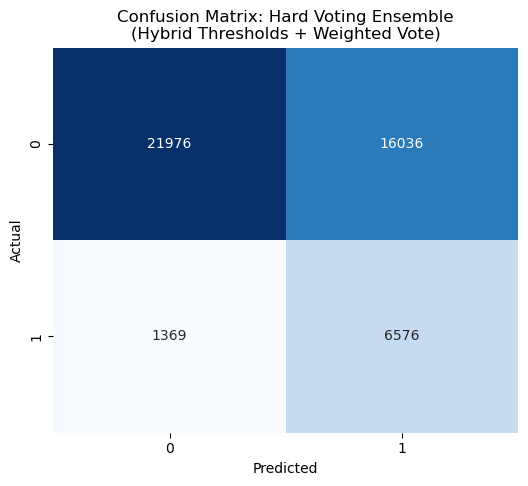

In [13]:
print("Evaluating Ensemble Model (Hard Voting with Optimized Thresholds except XGB)...")

# 1. Get Probabilities
# LR uses SCALED data (X_test_lin_scaled)
proba_lr = best_lr.predict_proba(X_test_lin_scaled)[:, 1]
# RF and XGB use RAW data (X_test)
proba_rf = best_rf.predict_proba(X_test)[:, 1]
proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

# 2. Apply Custom Thresholds
# LR and RF: Uses optimized thresholds
# XGB: Uses default 0.5 threshold (User Request: optimized threshold was too aggressive/imprecise)
pred_lr = (proba_lr >= lr_threshold).astype(int)
pred_rf = (proba_rf >= rf_threshold).astype(int)
pred_xgb = (proba_xgb >= 0.5).astype(int)

# 3. Weighted Voting
# Weights: LR=2, RF=1, XGB=1
# Logic: Give higher influence to the model best tuned for Recall (LR)
weighted_votes = (2 * pred_lr) + (1 * pred_rf) + (1 * pred_xgb)

# Decision Rule: Consensus >= 2
# - LR saying "Yes" (2 pts) is sufficient.
# - RF (1) + XGB (1) saying "Yes" is sufficient.
y_pred_ensemble = (weighted_votes >= 2).astype(int)

# 4. Evaluate
print("\n" + "="*20 + " Hard Voting Ensemble " + "="*20)
print(f"Weights: LR=2, RF=1, XGB=1")
print(f"Thresholds used: LR={lr_threshold:.2f}, RF={rf_threshold:.2f}, XGB=0.50 (Default)")

print(classification_report(y_test, y_pred_ensemble))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_ensemble)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: Hard Voting Ensemble\n(Hybrid Thresholds + Weighted Vote)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Evaluating Ensemble Model (Hard Voting with ALL Optimized Thresholds)...

==================== Hard Voting Ensemble (Fully Optimized) ====================
Weights: LR=2, RF=1, XGB=1
Thresholds used: LR=0.45, RF=0.40, XGB=0.75 (Optimized)
              precision    recall  f1-score   support

           0       0.93      0.63      0.75     38012
           1       0.31      0.79      0.44      7945

    accuracy                           0.66     45957
   macro avg       0.62      0.71      0.60     45957
weighted avg       0.83      0.66      0.70     45957


==================== Hard Voting Ensemble (Fully Optimized) ====================
Weights: LR=2, RF=1, XGB=1
Thresholds used: LR=0.45, RF=0.40, XGB=0.75 (Optimized)
              precision    recall  f1-score   support

           0       0.93      0.63      0.75     38012
           1       0.31      0.79      0.44      7945

    accuracy                           0.66     45957
   macro avg       0.62      0.71      0.60     4595

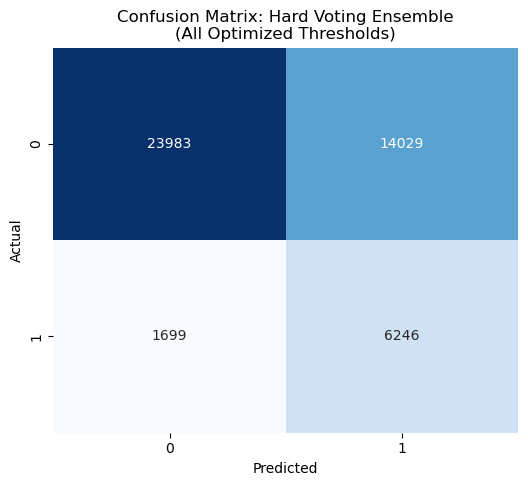

In [14]:
print("Evaluating Ensemble Model (Hard Voting with ALL Optimized Thresholds)...")

# 1. Get Probabilities
# LR uses SCALED data (X_test_lin_scaled)
proba_lr = best_lr.predict_proba(X_test_lin_scaled)[:, 1]
# RF and XGB use RAW data (X_test)
proba_rf = best_rf.predict_proba(X_test)[:, 1]
proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

# 2. Apply Custom Thresholds
# LR, RF, AND XGB: Use optimized thresholds
pred_lr = (proba_lr >= lr_threshold).astype(int)
pred_rf = (proba_rf >= rf_threshold).astype(int)
pred_xgb_opt = (proba_xgb >= xgb_threshold).astype(int) # Using optimized threshold here

# 3. Weighted Voting
# Weights: LR=2, RF=1, XGB=1
weighted_votes_opt = (2 * pred_lr) + (1 * pred_rf) + (1 * pred_xgb_opt)

# Decision Rule: Consensus >= 2
y_pred_ensemble_opt = (weighted_votes_opt >= 2).astype(int)

# 4. Evaluate
print("\n" + "="*20 + " Hard Voting Ensemble (Fully Optimized) " + "="*20)
print(f"Weights: LR=2, RF=1, XGB=1")
print(f"Thresholds used: LR={lr_threshold:.2f}, RF={rf_threshold:.2f}, XGB={xgb_threshold:.2f} (Optimized)")

print(classification_report(y_test, y_pred_ensemble_opt))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_ensemble_opt)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: Hard Voting Ensemble\n(All Optimized Thresholds)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## 9. Final Model Comparison Leaderboard

The table below provides a summative ranking of all models developed in this pipeline, comparing baseline, optimized, and ensemble iterations. Models are evaluated based on their ability to detect the positive class (Recall) and their overall balance (F1 Score).

## 9. Final Model Comparison Leaderboard

The table below provides a summative ranking of all models developed in this pipeline, comparing baseline, optimized, and ensemble iterations. Models are evaluated based on their ability to detect the positive class (Recall) and their overall balance (F1 Score).

In [15]:
# --- Final Model Comparison Leaderboard ---
from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score

# 1. Define Model Configurations
# Format: (Model Name, Prediction Array OR (Model Object, Test Data, Threshold))

leaderboard_configs = []

# --- A. Baseline Models (Default 0.5) ---
# Note: Baseline models (lr_model, rf_model, xgb_model) are available from Section 1
leaderboard_configs.append(("Baseline LR (Default)", (lr_model, X_test_lin_scaled, 0.5)))
leaderboard_configs.append(("Baseline RF (Default)", (rf_model, X_test, 0.5)))
leaderboard_configs.append(("Baseline XGB (Default)", (xgb_model, X_test, 0.5)))

# --- B. Optimized Models (Default 0.5) ---
# Available as best_lr, best_rf, best_xgb from Section 3
leaderboard_configs.append(("Optimized LR (Default)", (best_lr, X_test_lin_scaled, 0.5)))
leaderboard_configs.append(("Optimized RF (Default)", (best_rf, X_test, 0.5)))
leaderboard_configs.append(("Optimized XGB (Default)", (best_xgb, X_test, 0.5)))

# --- C. Optimized Models (Optimal Thresholds) ---
# Thresholds stored in `optimal_thresholds` dictionary
leaderboard_configs.append(("Optimized LR (Tuned Threshold)", (best_lr, X_test_lin_scaled, optimal_thresholds['Logistic Regression'])))
leaderboard_configs.append(("Optimized RF (Tuned Threshold)", (best_rf, X_test, optimal_thresholds['Random Forest'])))
leaderboard_configs.append(("Optimized XGB (Tuned Threshold)", (best_xgb, X_test, optimal_thresholds['XGBoost'])))

# --- D. Ensembles (Pre-calculated predictions) ---
# Calculated in Section 8
leaderboard_configs.append(("Ensemble (Hybrid Voting)", y_pred_ensemble))
leaderboard_configs.append(("Ensemble (Fully Optimized)", y_pred_ensemble_opt))


# 2. Calculate Metrics
results_list = []

for name, config in leaderboard_configs:
    # Determine predictions
    if isinstance(config, tuple):
        model, X_eval, threshold = config
        # Get probabilities
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_eval)[:, 1]
            y_pred = (y_proba >= threshold).astype(int)
        else:
            y_pred = model.predict(X_eval) # Fallback if no proba
    else:
        # Config is the prediction array itself
        y_pred = config

    # Calculate Metrics
    # Per-class Recall
    recalls = recall_score(y_test, y_pred, average=None)
    recall_0 = recalls[0] if len(recalls) > 0 else 0
    recall_1 = recalls[1] if len(recalls) > 1 else 0
    
    # Overall Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred) # Binary F1 for positive class
    prec = precision_score(y_test, y_pred, zero_division=0)
    
    results_list.append({
        'Model': name,
        'Accuracy': acc,
        'Recall (Diabetes)': recall_1,    # Critical Metric
        'Precision (Diabetes)': prec,
        'F1 Score (Diabetes)': f1,
        'Recall (Healthy)': recall_0
    })

# 3. Create DataFrame
leaderboard = pd.DataFrame(results_list)
leaderboard.set_index('Model', inplace=True)

# 4. Display sorted by specific goals
print("\n--- Leaderboard: Ranked by Diabetes Detection (Recall Class 1) ---")
display(leaderboard.sort_values(by='Recall (Diabetes)', ascending=False).style.format("{:.2%}").background_gradient(cmap='Greens', subset=['Recall (Diabetes)']))

print("\n--- Leaderboard: Ranked by F1 Score (Balanced Performance) ---")
display(leaderboard.sort_values(by='F1 Score (Diabetes)', ascending=False).style.format("{:.2%}").background_gradient(cmap='Greens', subset=['F1 Score (Diabetes)']))


--- Leaderboard: Ranked by Diabetes Detection (Recall Class 1) ---


,Accuracy,Recall (Diabetes),Precision (Diabetes),F1 Score (Diabetes),Recall (Healthy)
Model,,,,,
Optimized XGB (Default),30.92%,98.82%,19.87%,33.09%,16.73%
Baseline XGB (Default),58.39%,85.11%,27.38%,41.43%,52.81%
Ensemble (Hybrid Voting),62.13%,82.77%,29.08%,43.04%,57.81%
Optimized LR (Tuned Threshold),65.79%,78.62%,30.82%,44.28%,63.11%
Ensemble (Fully Optimized),65.78%,78.62%,30.81%,44.27%,63.09%
Optimized LR (Default),70.08%,72.10%,33.18%,45.45%,69.65%
Baseline LR (Default),70.21%,71.82%,33.26%,45.46%,69.88%
Optimized RF (Tuned Threshold),67.84%,70.69%,31.08%,43.18%,67.24%
Optimized XGB (Tuned Threshold),74.69%,62.89%,36.52%,46.21%,77.15%



--- Leaderboard: Ranked by F1 Score (Balanced Performance) ---


,Accuracy,Recall (Diabetes),Precision (Diabetes),F1 Score (Diabetes),Recall (Healthy)
Model,,,,,
Optimized XGB (Tuned Threshold),74.69%,62.89%,36.52%,46.21%,77.15%
Baseline LR (Default),70.21%,71.82%,33.26%,45.46%,69.88%
Optimized LR (Default),70.08%,72.10%,33.18%,45.45%,69.65%
Optimized RF (Default),74.41%,59.11%,35.56%,44.40%,77.61%
Optimized LR (Tuned Threshold),65.79%,78.62%,30.82%,44.28%,63.11%
Ensemble (Fully Optimized),65.78%,78.62%,30.81%,44.27%,63.09%
Optimized RF (Tuned Threshold),67.84%,70.69%,31.08%,43.18%,67.24%
Ensemble (Hybrid Voting),62.13%,82.77%,29.08%,43.04%,57.81%
Baseline XGB (Default),58.39%,85.11%,27.38%,41.43%,52.81%


In [16]:
# --- 5. Automated Recommendation: Best Overall Model ---

print("\n" + "="*60)
print(" AUTOMATED MODEL SELECTION")
print(" Criteria: Balanced Performance (Recall > 60% for BOTH classes) + Max F1 Score")
print("="*60)

# 1. Define "Balanced Recall" criteria
# Ensure both Healthy and Diabetes are detected reasonably well
leaderboard['Min Recall'] = leaderboard[['Recall (Healthy)', 'Recall (Diabetes)']].min(axis=1)

# 2. Filter Models
# Strict: Both classes > 60% recall (Good balance for imbalanced dataset)
# (Note: In binary screening, we want reasonably high sensitivity without crashing specificity)
candidates_strict = leaderboard[leaderboard['Min Recall'] >= 0.60]
candidates_loose  = leaderboard[leaderboard['Min Recall'] >= 0.40]

target_model = ""
reason = ""

if not candidates_strict.empty:
    # Pick the one with the highest F1 Score from the strictly balanced set
    target_model = candidates_strict['F1 Score (Diabetes)'].idxmax()
    reason = "Good Balance (>60% Recall for both) + Highest F1 Score"
elif not candidates_loose.empty:
    # Fallback to moderate balance
    target_model = candidates_loose['F1 Score (Diabetes)'].idxmax()
    reason = "Moderate Balance (>40% Recall for both) + Highest F1 Score"
else:
    # Fallback: Just maximize F1 (likely favors one class, but best trade-off available)
    target_model = leaderboard['F1 Score (Diabetes)'].idxmax()
    reason = "No balanced models found. Selecting based on highest F1 Score."

# 3. Display Result
best_row = leaderboard.loc[target_model]

print(f"\n CHAMPION MODEL: {target_model}")
print(f"   Reason: {reason}")
print("-" * 40)
print(f"   Accuracy:            {best_row['Accuracy']:.2%}")
print(f"   F1 Score (Diabetes): {best_row['F1 Score (Diabetes)']:.2%}")
print("-" * 40)
print(f"   Recall (Diabetes):   {best_row['Recall (Diabetes)']:.2%} (Sensitivity)")
print(f"   Recall (Healthy):    {best_row['Recall (Healthy)']:.2%} (Specificity)")
print(f"   Precision (Diabetes):{best_row['Precision (Diabetes)']:.2%}")


 AUTOMATED MODEL SELECTION
 Criteria: Balanced Performance (Recall > 60% for BOTH classes) + Max F1 Score

 CHAMPION MODEL: Optimized XGB (Tuned Threshold)
   Reason: Good Balance (>60% Recall for both) + Highest F1 Score
----------------------------------------
   Accuracy:            74.69%
   F1 Score (Diabetes): 46.21%
----------------------------------------
   Recall (Diabetes):   62.89% (Sensitivity)
   Recall (Healthy):    77.15% (Specificity)
   Precision (Diabetes):36.52%
